#### IMPORTING NECESSARY LIBRARIES

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

#### INPUT PARAMETERS

In [2]:
N = 5        # Number of biomarkers
labels = []  # Biomarker Labels

for number in range(N):
    labels.append('Biomarker '+str(number))

Z_scores = np.array([[1,2,3]]*N)
Z_max = np.array([5]*N)

Z_scores[0,2] = 0
Z_max[0] = 3

Z_scores[2,[1,2]]=0
Z_max[2] = 2

In [3]:
Z_scores

array([[1, 2, 0],
       [1, 2, 3],
       [1, 0, 0],
       [1, 2, 3],
       [1, 2, 3]])

In [4]:
Z_max

array([3, 5, 2, 5, 5])

#### GENERATING BIOMARKER TRAJECTORIES FOR DISTINCT SUBTYPES

In [5]:
def generate_random_sequence(Z_scores,Z_max,labels,number_of_subtypes = 1,plot=True):
    
    number_of_biomarkers = len(labels)
    number_of_stages = Z_scores[Z_scores!=0].shape[0]
    stages = np.arange(1,number_of_stages+1)
    biomarkers_list = np.arange(0,Z_scores.shape[0]).tolist()
    sequences = []
    scores = []

    for subtype in range(number_of_subtypes):
        
        event_sequence = []
        event_scores = []
        possible_biomarkers = copy.deepcopy(biomarkers_list)
        score_position = np.array([0]*number_of_biomarkers)
        
        for stage in range(number_of_stages):
            selected_biomarker = random.choice(possible_biomarkers)
            event_sequence.append(selected_biomarker)
            event_scores.append(score_position[selected_biomarker].item()+1)
            biomarker_z_scores = Z_scores[selected_biomarker]
            score_position[selected_biomarker]+=1
            biomarker_stage = score_position[selected_biomarker]
            
            if (biomarker_stage>biomarker_z_scores.shape[0]-1 or biomarker_z_scores[biomarker_stage]==0):
                possible_biomarkers.remove(selected_biomarker)

        sequences.append(event_sequence)
        scores.append(event_scores)

        if not plot:

            print('SUBTYPE',subtype+1)
            print('At the beginning of the progression (stage 0) the biomarkers have scores of 0')
            print('At the stages:    ',stages)
            print('The biomarkers:   ',event_sequence)
            print('Reach z-scores of:',event_scores)
            print('At the end of the progression (stage',len(event_scores)+2,') the biomarkers reach scores of:',Z_max)
            print('The z-score model assumes individuals belong to some unknown stage of this progression,')
            print('with gaussian noise with a standard deviation of 1 for each biomarker','\n')
        

    if plot:

        rows = number_of_subtypes//2 + number_of_subtypes%2
        columns = 2
        fig,ax = plt.subplots(rows,columns,figsize=(10,rows*3.5))
        for index in range(number_of_subtypes):
            for biomarker in biomarkers_list:
                positions = np.array(sequences[index])==biomarker
                biomarker_stages = stages[positions]  
                biomarker_scores = np.array(scores[index])[positions]
                biomarker_stages = np.insert(biomarker_stages,0,0)
                biomarker_stages = np.append(biomarker_stages,number_of_stages+1)
                biomarker_scores = np.insert(biomarker_scores,0,0)
                biomarker_scores = np.append(biomarker_scores,Z_max[biomarker])
                row,column = index//2,index%2
                ax[row,column].plot(biomarker_stages,biomarker_scores,label = labels[biomarker])
        
            ax[row,column].set_xlabel("SuStaIn Stage")        
            ax[row,column].set_ylabel("Z-Score")      
            ax[row,column].set_xticks([0,2,4,6,8,10,12])  
            ax[row,column].set_yticks([0,1,2,3,4,5]) 
            ax[row,column].set_title("Subtype " + str(index+1))  
            ax[row,column].legend(fontsize='small')

        if number_of_subtypes%2==1:
            ax[rows-1,columns-1].set_axis_off()
            
        fig.tight_layout(h_pad=1.0)
        plt.show()
        
    return np.array(sequences),np.array(scores)

In [6]:
sequences,scores = generate_random_sequence(Z_scores,Z_max,labels,number_of_subtypes=3,plot=False)

SUBTYPE 1
At the beginning of the progression (stage 0) the biomarkers have scores of 0
At the stages:     [ 1  2  3  4  5  6  7  8  9 10 11 12]
The biomarkers:    [4, 4, 4, 2, 3, 1, 1, 1, 0, 3, 3, 0]
Reach z-scores of: [1, 2, 3, 1, 1, 1, 2, 3, 1, 2, 3, 2]
At the end of the progression (stage 14 ) the biomarkers reach scores of: [3 5 2 5 5]
The z-score model assumes individuals belong to some unknown stage of this progression,
with gaussian noise with a standard deviation of 1 for each biomarker 

SUBTYPE 2
At the beginning of the progression (stage 0) the biomarkers have scores of 0
At the stages:     [ 1  2  3  4  5  6  7  8  9 10 11 12]
The biomarkers:    [2, 1, 1, 0, 4, 0, 4, 1, 4, 3, 3, 3]
Reach z-scores of: [1, 1, 2, 1, 1, 2, 2, 3, 3, 1, 2, 3]
At the end of the progression (stage 14 ) the biomarkers reach scores of: [3 5 2 5 5]
The z-score model assumes individuals belong to some unknown stage of this progression,
with gaussian noise with a standard deviation of 1 for each biomar

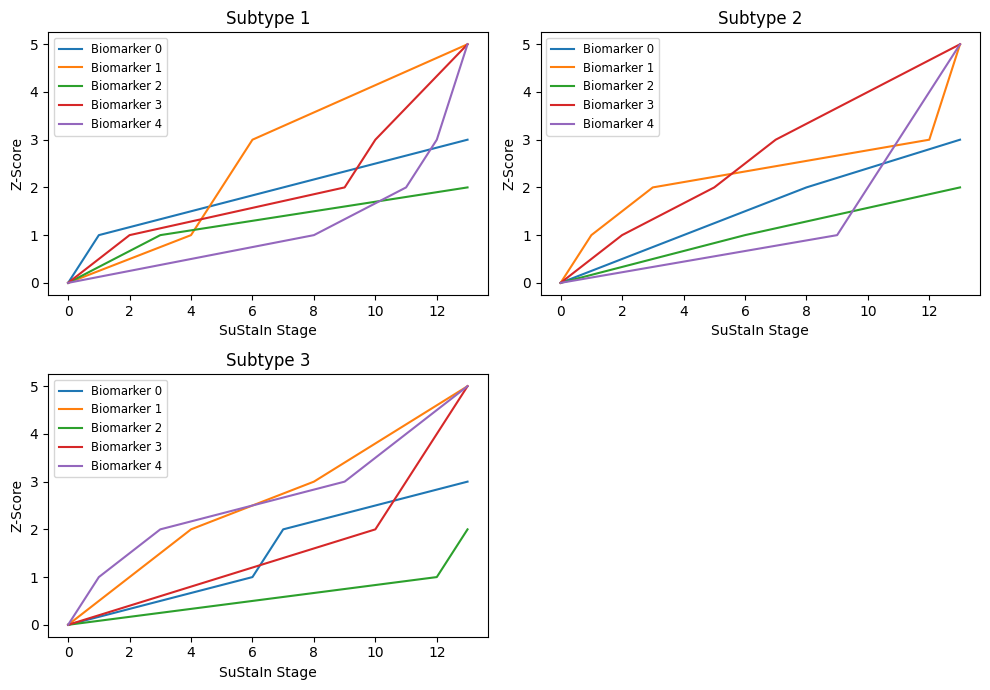

In [7]:
sequences,scores = generate_random_sequence(Z_scores,Z_max,labels,number_of_subtypes=3,plot=True)

#### GENERATING INPUT DATA

In [8]:
def generate_data_zscore(patient_subtypes,patient_stages,sequences,Z_scores,Z_max,labels):
    
    number_of_biomarkers = len(labels)
    number_of_patients = len(patient_stages)
    number_of_subtypes = len(sequences)
    number_of_stages = Z_scores[Z_scores!=0].shape[0] 
    
    stages = np.arange(1,number_of_stages+1)
    stage_values = np.zeros((number_of_biomarkers,number_of_stages+2,number_of_subtypes))
    std_zscore = np.array([1]*number_of_biomarkers)
    
    for subtype in range(number_of_subtypes):
        sequence = sequences[subtype]
        for biomarker in range(number_of_biomarkers):
            stage_index = sequence==biomarker
            z_score = Z_scores[biomarker]
            event_location = np.array([0] + stages[stage_index].tolist() + [number_of_stages+1])
            event_value = np.array([0] + z_score[z_score>0].tolist() + [Z_max[biomarker]])
            scores = np.array([0.0])
            for index in range(len(event_location)-1):
                step_scores = np.linspace(event_value[index],event_value[index+1],event_location[index+1]-event_location[index]+1)
                scores = np.append(scores,step_scores[1:])
            stage_values[biomarker,:,subtype]=scores

    data = stage_values[:,patient_stages,patient_subtypes].T
    noise = norm.ppf(np.random.rand(number_of_patients,number_of_biomarkers))*np.tile(std_zscore,(number_of_patients,1))
    return data,data+noise,stage_values

In [10]:
patient_stages = np.array([0])
patient_subtypes = np.array([1])
sequences = np.array([[4,3,4,2,3,0,1,0,3,4,1,1],[0,3,0,2,4,4,1,4,1,3,1,3]])

original_data,noised_data,stage_scores = generate_data_zscore(patient_subtypes,patient_stages,sequences,Z_scores,Z_max,labels)
stage_scores

array([[[0.        , 0.        ],
        [0.16666667, 1.        ],
        [0.33333333, 1.5       ],
        [0.5       , 2.        ],
        [0.66666667, 2.1       ],
        [0.83333333, 2.2       ],
        [1.        , 2.3       ],
        [1.5       , 2.4       ],
        [2.        , 2.5       ],
        [2.2       , 2.6       ],
        [2.4       , 2.7       ],
        [2.6       , 2.8       ],
        [2.8       , 2.9       ],
        [3.        , 3.        ]],

       [[0.        , 0.        ],
        [0.14285714, 0.14285714],
        [0.28571429, 0.28571429],
        [0.42857143, 0.42857143],
        [0.57142857, 0.57142857],
        [0.71428571, 0.71428571],
        [0.85714286, 0.85714286],
        [1.        , 1.        ],
        [1.25      , 1.5       ],
        [1.5       , 2.        ],
        [1.75      , 2.5       ],
        [2.        , 3.        ],
        [3.        , 4.        ],
        [5.        , 5.        ]],

       [[0.        , 0.        ],
        [0

#### GENERATING PATIENTS SIMULATED DATA

In [32]:
number_of_biomarkers = 5         
number_of_subtypes   = 2      
patient_count = 500       
control_count = 100  
labels = []

for number in range(number_of_biomarkers):
    labels.append('Biomarker '+str(number))

Z_scores = np.array([[1,2,3]]*number_of_biomarkers)
Z_max = np.array([5]*number_of_biomarkers)
sequences =  np.array([[4,3,4,3,1,3,2,4,1,1,0,2,2,0,0],[4,3,1,2,4,4,3,0,2,3,1,1,0,0,2]])

proportion   = np.array([1+0.5*x for x in range(number_of_subtypes)])
proportion = np.flip(proportion/np.sum(proportion))

number_of_stages = Z_scores[Z_scores!=0].shape[0]+1
patient_subtypes = np.random.choice(range(number_of_subtypes),patient_count,replace=True,p=proportion)
control_stages = np.zeros(control_count,dtype=int)
patient_stages = np.random.randint(1,number_of_stages,size=patient_count-control_count,dtype=int)
patient_stages = np.concatenate((control_stages,patient_stages),axis=0)

In [33]:
def generate_data_zscore(patient_subtypes,patient_stages,sequences,Z_scores,Z_max,labels):
    
    number_of_biomarkers = len(labels)
    number_of_patients = len(patient_stages)
    number_of_subtypes = len(sequences)
    number_of_stages = Z_scores[Z_scores!=0].shape[0]
    
    stages = np.arange(1,number_of_stages+1)
    stage_values = np.zeros((number_of_biomarkers,number_of_stages+2,number_of_subtypes))
    std_zscore = np.array([1]*number_of_biomarkers)
    
    for subtype in range(number_of_subtypes):
        sequence = sequences[subtype]
        for biomarker in range(number_of_biomarkers):
            stage_index = sequence==biomarker
            z_score = Z_scores[biomarker]
            event_location = np.array([0] + stages[stage_index].tolist() + [number_of_stages+1])
            event_value = np.array([0] + z_score[z_score>0].tolist() + [Z_max[biomarker]])
            scores = np.array([0.0])
            for index in range(len(event_location)-1):
                step_scores = np.linspace(event_value[index],event_value[index+1],event_location[index+1]-event_location[index]+1)
                scores = np.append(scores,step_scores[1:])
            stage_values[biomarker,:,subtype]=scores

    data = stage_values[:,patient_stages,patient_subtypes].T
    noise = norm.ppf(np.random.rand(number_of_patients,number_of_biomarkers))*np.tile(std_zscore,(number_of_patients,1))
    return data,data+noise,stage_values

In [34]:
original_data, noised_data, stage_scores = generate_data_zscore\
                                          (patient_subtypes,patient_stages,sequences,Z_scores,Z_max,labels)

In [35]:
stage_scores

array([[[0.        , 0.        ],
        [0.09090909, 0.125     ],
        [0.18181818, 0.25      ],
        [0.27272727, 0.375     ],
        [0.36363636, 0.5       ],
        [0.45454545, 0.625     ],
        [0.54545455, 0.75      ],
        [0.63636364, 0.875     ],
        [0.72727273, 1.        ],
        [0.81818182, 1.2       ],
        [0.90909091, 1.4       ],
        [1.        , 1.6       ],
        [1.33333333, 1.8       ],
        [1.66666667, 2.        ],
        [2.        , 3.        ],
        [3.        , 4.        ],
        [5.        , 5.        ]],

       [[0.        , 0.        ],
        [0.2       , 0.33333333],
        [0.4       , 0.66666667],
        [0.6       , 1.        ],
        [0.8       , 1.125     ],
        [1.        , 1.25      ],
        [1.25      , 1.375     ],
        [1.5       , 1.5       ],
        [1.75      , 1.625     ],
        [2.        , 1.75      ],
        [3.        , 1.875     ],
        [3.33333333, 2.        ],
        [3.6

#### GENERATING CONTROLS POPULATION DATA